<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#ID3决策树实验验证" data-toc-modified-id="ID3决策树实验验证-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>ID3决策树实验验证</a></span><ul class="toc-item"><li><span><a href="#ID3-算法" data-toc-modified-id="ID3-算法-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>ID3 算法</a></span></li><li><span><a href="#sklearn-代码验证" data-toc-modified-id="sklearn-代码验证-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>sklearn 代码验证</a></span></li><li><span><a href="#可视化" data-toc-modified-id="可视化-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>可视化</a></span></li><li><span><a href="#使用鸢尾花数据集的所有数据进行训练和测试" data-toc-modified-id="使用鸢尾花数据集的所有数据进行训练和测试-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>使用鸢尾花数据集的所有数据进行训练和测试</a></span></li></ul></li></ul></div>

# ID3决策树实验验证

## ID3 算法

In [1]:
import numpy as np
from collections import Counter
from math import log # 自然对数为底
import pandas as pd

In [2]:
class DTNode:
    def __init__(self, i_feature=None, label=None):
        self.i_feature = i_feature
        self.label = label
        self.tree = {}
        
    def isLeaf(self):
        return len(self.tree) == 0
    
    def addChild(self, feature_value, child_node):
        self.tree[feature_value] = child_node
        
    def _predict(self, x):
        if self.isLeaf():
            return self.label
        return self.tree[x[self.i_feature]]._predict(x)
    
    def predict(self, X):
        result = []
        for x in X:
            result.append(self._predict(x))
        return result
    
    def __repr__(self):
        return 'label={}, i_feature={}, subtree={}'.format(self.label, self.i_feature, self.tree)

In [3]:
class ID3Tree:
    def __init__(self, threshold=0.1):
        self.threshold = threshold
        self.root = None
    
    '''
    function : 计算数据集的经验熵
    '''
    def CalcDatasetEntropy(self, Y):
        N = len(Y)
        labels_counter = Counter(Y)
        return -sum([Ni/N*log(Ni/N, 2) for Ni in labels_counter.values()])
    
    '''
    function : 计算数据集的条件熵
    '''
    def CalcConditionEntropy(self, X, Y, i_feature):
        N = len(X)
        subsets = {}
        for i in range(N):
            feature_value = X[i][i_feature]
            if feature_value not in subsets:
                subsets[feature_value] = []
            subsets[feature_value].append(Y[i])
        return sum([len(subset)/N*self.CalcDatasetEntropy(subset) \
                    for subset in subsets.values()])
    
    '''
    function : 选取最佳的特征
    '''
    def SelectBestFeature(self, X, Y, used):
        feature_info = []
        for i in range(len(X[0])):
            if i in used:
                continue
            feature_info.append((i, self.CalcConditionEntropy(X, Y, i)))
        return min(feature_info, key=lambda x:x[-1])
    
    '''
    function : 使用数训练得到ID3决策树
    '''
    def train(self, X, Y, used):
        if (len(X[0]) - len(used) == 0):
            return DTNode(label=max(Counter(Y), key=lambda x:x[-1])[0])
        
        if len(Counter(Y)) == 1:
            return DTNode(label=Y[0])
        
        best_i_feature, best_cond_entropy = self.SelectBestFeature(X, Y, used)
        
        # 信息熵小于阈值
        if self.CalcDatasetEntropy(Y) - best_cond_entropy < self.threshold:
            return DTNode(label=max(Counter(Y), key=lambda x:x[-1])[0])    
        
        # 非叶子节点
        current_dtnode = DTNode(i_feature=best_i_feature)
        used.append(best_i_feature)
        
        # 重新划分 X 与 Y
        subsets = {}
        for i in range(len(X)):
            feature_value = X[i][best_i_feature]
            if feature_value not in subsets:
                subsets[feature_value] = []
            subsets[feature_value].append((X[i], Y[i]))
        
        # 处理每一个特征离散值对应的数据
        for feature_value, newdataset in subsets.items():
            New_X = np.array([xy[0] for xy in newdataset])
            New_Y = np.array([xy[1] for xy in newdataset])
            child = self.train(New_X, New_Y, used)
            current_dtnode.addChild(feature_value, child)
        
        return current_dtnode
    
    '''
    function : 生成决策树
    '''
    def fit(self, X, Y):
        self.root = self.train(X, Y, [])
        print(self.root)
        print('ID1 dection tree training completed !')
        
    '''
    预测
    '''
    def predict(self, X):
        return self.root.predict(X)
    

In [4]:
datasets = [['青年', '否', '否', '一般', '否'],
            ['青年', '否', '否', '好', '否'],
            ['青年', '是', '否', '好', '是'],
            ['青年', '是', '是', '一般', '是'],
            ['青年', '否', '否', '一般', '否'],
            ['中年', '否', '否', '一般', '否'],
            ['中年', '否', '否', '好', '否'],
            ['中年', '是', '是', '好', '是'],
            ['中年', '否', '是', '非常好', '是'],
            ['中年', '否', '是', '非常好', '是'],
            ['老年', '否', '是', '非常好', '是'],
            ['老年', '否', '是', '好', '是'],
            ['老年', '是', '否', '好', '是'],
            ['老年', '是', '否', '非常好', '是'],
            ['老年', '否', '否', '一般', '否'],
            ]
labels = [u'年龄', u'有工作', u'有自己的房子', u'信贷情况', u'类别']
train_data = pd.DataFrame(datasets, columns=labels)
X = np.array(train_data.iloc[:, :-1])
Y = np.array(train_data.iloc[:, -1])
train_data

,年龄,有工作,有自己的房子,信贷情况,类别
0,青年,否,否,一般,否
1,青年,否,否,好,否
2,青年,是,否,好,是
3,青年,是,是,一般,是
4,青年,否,否,一般,否
5,中年,否,否,一般,否
6,中年,否,否,好,否
7,中年,是,是,好,是
8,中年,否,是,非常好,是
9,中年,否,是,非常好,是


In [5]:
id3_dt = ID3Tree()
id3_dt.fit(X, Y)

label=None, i_feature=2, subtree={'否': label=None, i_feature=1, subtree={'否': label=否, i_feature=None, subtree={}, '是': label=是, i_feature=None, subtree={}}, '是': label=是, i_feature=None, subtree={}}
ID1 dection tree training completed !


In [6]:
XTEST = [['老年', '否', '否', '一般'],
        ['中年', '是', '否', '一般'],
        ['中年', '否', '否', '一般'],
        ['青年', '否', '否', '一般'],
        ['青年', '否', '否', '好'],
        ['青年', '否', '是', '一般'],
        ]
id3_dt.predict(XTEST)

['否', '是', '否', '否', '否', '是']

## sklearn 代码验证

In [7]:
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier

In [8]:
age_str = ['青年', '中年', '老年']
age = preprocessing.LabelEncoder()
age.fit(age_str)
print(age.transform(age_str))

yes_str = ['是', '否']
yes = preprocessing.LabelEncoder()
yes.fit(yes_str)
print(yes.transform(yes_str))

good_str = ['一般', '好', '非常好']
good = preprocessing.LabelEncoder()
good.fit(good_str)
print(good.transform(good_str))

[2 0 1]
[1 0]
[0 1 2]


In [9]:
sk_train_data = train_data.copy(deep = True)
sk_train_data[u'年龄'] = sk_train_data[u'年龄'].apply(lambda x:age.transform([x])[0])
sk_train_data[u'有工作'] = sk_train_data[u'有工作'].apply(lambda x:yes.transform([x])[0])
sk_train_data[u'有自己的房子'] = sk_train_data[u'有自己的房子'].apply(lambda x:yes.transform([x])[0])
sk_train_data[u'信贷情况'] = sk_train_data[u'信贷情况'].apply(lambda x:good.transform([x])[0])
sk_train_data[u'类别'] = sk_train_data[u'类别'].apply(lambda x:float(yes.transform([x])[0]))
sk_train_data

,年龄,有工作,有自己的房子,信贷情况,类别
0,2,0,0,0,0.0
1,2,0,0,1,0.0
2,2,1,0,1,1.0
3,2,1,1,0,1.0
4,2,0,0,0,0.0
5,0,0,0,0,0.0
6,0,0,0,1,0.0
7,0,1,1,1,1.0
8,0,0,1,2,1.0
9,0,0,1,2,1.0


In [10]:
X = np.array(sk_train_data.iloc[:, :-1])
Y = np.array(sk_train_data.iloc[:, -1])
clf = DecisionTreeClassifier(criterion = 'entropy')
clf.fit(X, Y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [11]:
sk_test_data = pd.DataFrame(XTEST, columns = labels[:-1])
sk_test_data

,年龄,有工作,有自己的房子,信贷情况
0,老年,否,否,一般
1,中年,是,否,一般
2,中年,否,否,一般
3,青年,否,否,一般
4,青年,否,否,好
5,青年,否,是,一般


In [12]:
sk_test_data[u'年龄'] = sk_test_data[u'年龄'].apply(lambda x:age.transform([x])[0])
sk_test_data[u'有工作'] = sk_test_data[u'有工作'].apply(lambda x:yes.transform([x])[0])
sk_test_data[u'有自己的房子'] = sk_test_data[u'有自己的房子'].apply(lambda x:yes.transform([x])[0])
sk_test_data[u'信贷情况'] = sk_test_data[u'信贷情况'].apply(lambda x:good.transform([x])[0])
sk_test_data

,年龄,有工作,有自己的房子,信贷情况
0,1,0,0,0
1,0,1,0,0
2,0,0,0,0
3,2,0,0,0
4,2,0,0,1
5,2,0,1,0


In [13]:
XTEST = np.array(sk_test_data.iloc[:, :])
print(yes.inverse_transform([int(r) for r in clf.predict(XTEST)]))

['否' '是' '否' '否' '否' '是']


## 可视化

In [14]:
from sklearn.tree import export_graphviz
import graphviz
import pydot
import os

In [15]:
os.environ['PATH'] = os.environ['PATH'] + \
(';D:\\Program Files (x86)\\Graphviz2.38\\bin\\')

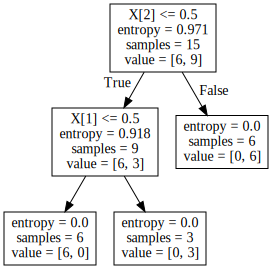

In [16]:
export_graphviz(clf, out_file = "sklearn_dt_tree.dot")
with open('sklearn_dt_tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [17]:
(graph, ) = pydot.graph_from_dot_file('sklearn_dt_tree.dot')
graph.write_pdf('sklearn_dt_tree.pdf')

## 使用鸢尾花数据集的所有数据进行训练和测试

In [18]:
from sklearn.model_selection import train_test_split

iris_npz = np.load('iris_full.npz')
data = iris_npz['data']
X = iris_npz['X']
Y = iris_npz['Y']
XTRAIN, XTEST, YTRAIN, YTEST = train_test_split(X, Y, test_size = 0.3)

In [19]:
clf = DecisionTreeClassifier(criterion = 'gini')
clf.fit(XTRAIN, YTRAIN)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [20]:
clf.score(XTEST, YTEST)

0.9333333333333333

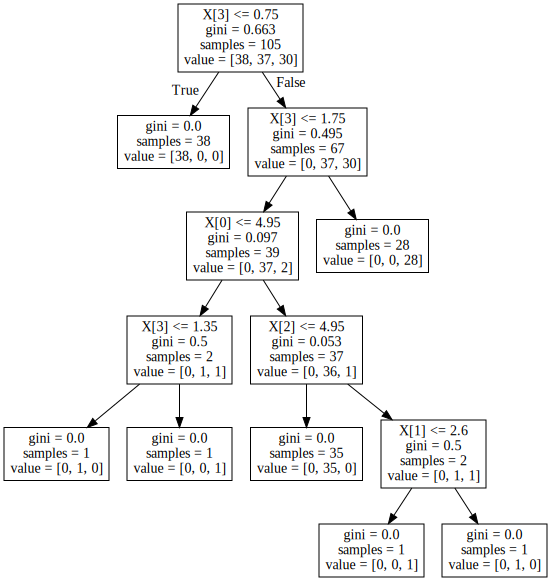

In [21]:
export_graphviz(clf, out_file = "sklearn_iris_dt_tree.dot")
with open('sklearn_iris_dt_tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)